In [1]:
%load_ext autoreload
%autoreload 2

from Shared.specific_CNB_sim import *

sim_name = f"rel_EOMs"
sim_folder = f"sim_output/{sim_name}"
fig_folder = "Shared/CNB_plots"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV

simdata = SimData(sim_folder)

## Distances

### Fermi-Dirac no-gravity vs. CNB sim

629436 (82.0%) neutrinos selected.


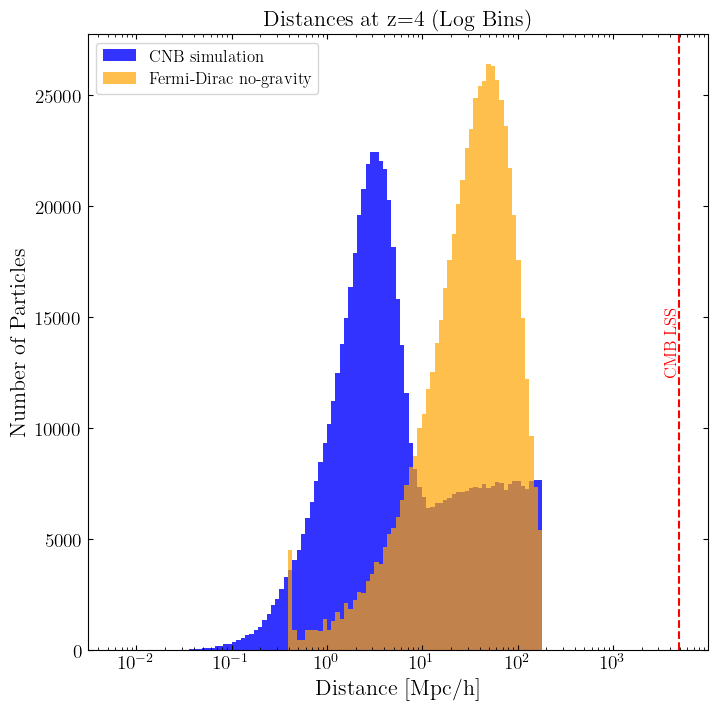

'\n'

In [13]:
def distances_histogram_log_bins(
    distances, Fermi_Dirac, CMB_LSS, ax_lims, fig_dir, args):
    """
    Plot a histogram of distances with logarithmically spaced bins.
    """

    # Avoiding zero distance for log scale
    distances_above0 = distances[distances > 0]

    # From kpc to Mpc
    distances_Mpc = distances_above0/1e3

    # Generating logarithmically spaced bins
    log_bins = jnp.logspace(
        jnp.log10(jnp.min(distances_Mpc)), 
        jnp.log10(jnp.max(distances_Mpc)), 
        100)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        distances_Mpc, bins=log_bins, 
        color='blue', label='CNB simulation', alpha=0.8)

    # Plot Fermi-Dirac sampled momentum comoving distances
    if Fermi_Dirac is not None:
        Fermi_Dirac_Mpc = Fermi_Dirac/1e3
        ax.hist(
            Fermi_Dirac_Mpc, bins=log_bins, 
            color='orange', label='Fermi-Dirac no-gravity', alpha=0.7)

    # Plot Distance to CMB LSS
    if CMB_LSS:
        z_end_sim = 4.0
        CMB_LSS_dist = Cosmo.get_LSS_distance(
            z_end_sim, 1.0, 0.0, Params())/(args.Mpc/args.h)
        ax.axvline(CMB_LSS_dist, c='red', ls='dashed')

        # Compute geometric mean for y-position of text
        y_lower, y_upper = ax.get_ylim()
        # y_mid = np.sqrt(y_lower * y_upper)
        y_mid = (y_upper - y_lower)/2

        # Add rotated text
        ax.text(
            CMB_LSS_dist, y_mid, 'CMB LSS', color='red', 
            rotation=90, va='center', ha='right')

    ax.set_xscale('log')
    ax.set_title("Distances at z=4 (Log Bins)")
    ax.set_xlabel("Distance [Mpc/h]")
    ax.set_ylabel("Number of Particles")
    ax.legend(loc='upper left')

    if ax_lims is not None:
        ax.set_xlim(ax_lims[0], ax_lims[1])
        ax.set_ylim(ax_lims[2], ax_lims[3])

    plt.savefig(f'{fig_dir}/distances_histogram_log_bins.pdf', bbox_inches='tight')
    plt.show(); plt.close()


# Compute CDF over a fine grid
@jax.jit
def CDF_Fermi_Dirac_grid(T, p_min, p_max):
    p_vals = jnp.linspace(p_min, p_max, 10_000)
    CDF_vals = p_vals - T*jnp.log(jnp.exp(p_vals/T)+1) + T*jnp.log(2)
    norm_factor = CDF_vals[-1]
    CDF_vals /= norm_factor
    return p_vals, CDF_vals


# Sample from the Fermi-Dirac distribution using inverse sampling
@jax.jit
def Fermi_Dirac_sampling(T, p_min, p_max, args):
    
    # Precompute CDF values
    p_vals, CDF_vals = CDF_Fermi_Dirac_grid(T, p_min, p_max)

    # Generate uniform random samples
    u_samples = jax.random.uniform(args.key, shape=(neutrinos_current,))

    # Inverse sampling using searchsorted
    indices = jnp.searchsorted(CDF_vals[:-1], u_samples)
    p_samples = p_vals[indices]
    
    return p_samples


def UTIL_select_neutrinos_momentum_filter(vectors, nu_mass, args):
    
    # Extract velocities and attach units
    zBack_velocities = vectors[..., -1, 3:6]*args.kpc/args.s

    # note on selection
    # For z0 vectors, roughly selects 65%
    # For z4 vectors, roughly selects 82%

    # Convert velocities to momentum magnitudes
    momentum = zBack_velocities * nu_mass
    mags = jnp.linalg.norm(momentum, axis=-1)

    # Filter based on momentum values
    selection = (mags >= 0.01*args.T_CNB) & (mags <= 10*args.T_CNB)
    neutrinos = jnp.count_nonzero(selection)

    percent = neutrinos/len(vectors)*100
    print(f'{neutrinos} ({percent:.1f}%) neutrinos selected.')

    return vectors[selection]


# Load sim output
halo1_vecs = jnp.load(f"{sim_folder}/vectors_halo1.npy").reshape(-1, 2, 6)
# print(halo1_vecs.shape)

# Specified neutrino selection
nu_mass_choice = 0.05*Params.eV
cut_vectors = UTIL_select_neutrinos_momentum_filter(
    halo1_vecs, nu_mass_choice, Params())
# print(cut_vectors.shape)

# Get distance magnitudes
sim_distances = jnp.linalg.norm(cut_vectors[..., -1, :3], axis=-1)
# print(sim_distances.shape)


### ------------------------------------------------------------- ###
### Generate Fermi-Dirac sampled momenta and convert to distances ###
### ------------------------------------------------------------- ###
z_end_sim = 4.0
# p_min, p_max = simdata.p_start*Params.T_CNB, simdata.p_stop*Params.T_CNB
p_min, p_max = 0.01*Params.T_CNB, 10*Params.T_CNB
neutrinos_current = len(sim_distances)

Fermi_Dirac_p_samples = Fermi_Dirac_sampling(
    Params.T_CNB, p_min, p_max, Params())
# print(Fermi_Dirac_p_samples.shape)

# Fermi_Dirac_distances = jnp.array([
#     Cosmo.get_LSS_distance(
#         z_end_sim, p_0=p, m_nu=nu_mass_choice, args=Params())
#     for p in Fermi_Dirac_p_samples])

Fermi_Dirac_distances = Cosmo.get_LSS_distance(
    z_end_sim, Fermi_Dirac_p_samples, nu_mass_choice, Params())
Fermi_Dirac_distances /= (Params.kpc/Params.h)
# print(Fermi_Dirac_distances.shape)


distances_histogram_log_bins(
    distances=sim_distances, Fermi_Dirac=Fermi_Dirac_distances, 
    CMB_LSS=True, ax_lims=None, fig_dir=fig_folder, args=Params())

# distances=Zimmer_distances_zBack, Fermi_Dirac=Fermi_Dirac_distances, 
# CMB_LSS=True)

In [12]:
simdata.p_stop

400.0

### 2D histogram

### How many neutrino reached what distance?

### Distances to CNB/CMB LSS (at z_LSS !) vs. neutrino masses

### Distances to CNB/CMB LSS vs. redshift (for specific neutrino mass)

## Momenta

### Sampling Fermi-Dirac momenta

## Neutrino Facts

### Non-relativistic transition

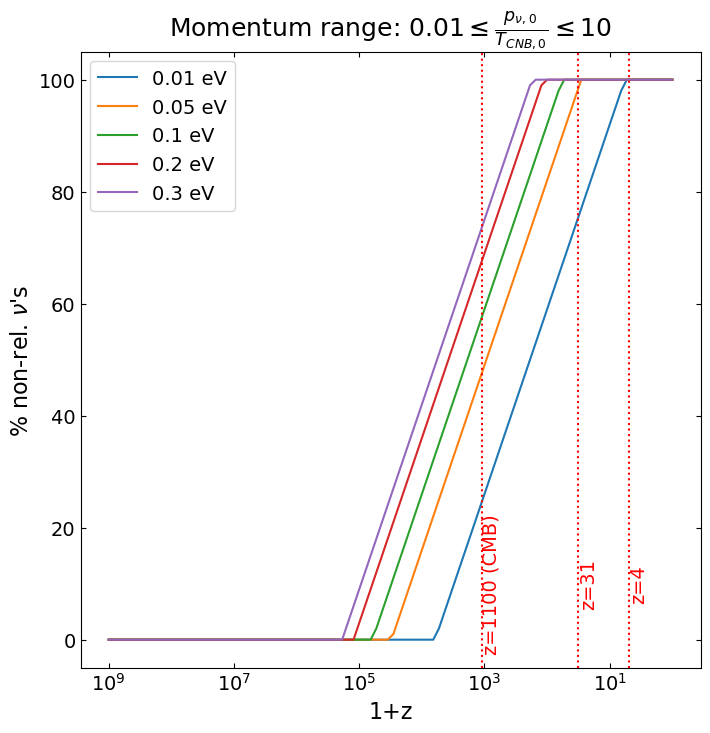

In [28]:
def get_z_nr(m_nu, p_nu):
    return m_nu/p_nu - 1

p_range = jnp.geomspace(0.01, 10, 100)*Params.T_CNB

redshifts = Utils.make_logz_arr(1e9, 0, 100)  # CNB to today
masses = nu_m_picks

# Calculate percentages
percentages = np.zeros((len(masses), len(redshifts)))
for i, m in enumerate(masses):
    z_nr = get_z_nr(m, p_range)
    for j, z in enumerate(redshifts):
        percentages[i, j] = jnp.mean(z_nr >= z) * 100

# Plot
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)
for i, m in enumerate(masses):
    ax.semilogx(1+redshifts, percentages[i, :], label=f'{m} eV')

mid_y = 10
ax.axvline(4+1, color="red", ls="dotted")
ax.text(4.9, mid_y, 'z=4', color='red', rotation=90, verticalalignment='center')
ax.axvline(31+1, color="red", ls="dotted")
ax.text(31+1e-1, mid_y, 'z=31', color='red', rotation=90, verticalalignment='center')
ax.axvline(1100+1, color="red", ls="dotted")
ax.text(1100+1e-1, mid_y, 'z=1100 (CMB)', color='red', rotation=90, verticalalignment='center')

ax.set_xlabel("1+z")
ax.set_ylabel(fr"$\%$ non-rel. $\nu$'s")
ax.invert_xaxis()
ax.legend()
ax.set_title(r"Momentum range: $0.01 \leq \frac{p_{\nu,0}}{T_{CNB,0}} \leq 10$")
plt.show(); plt.close()

When their momentum reaches the order of their mass, then we can say they become non-relativistic? If yes, then the simple formula of $z \simeq 1100 m_\nu / 0.58 eV$ is not precise enough for us?

Text(0, 0.5, '1+z')

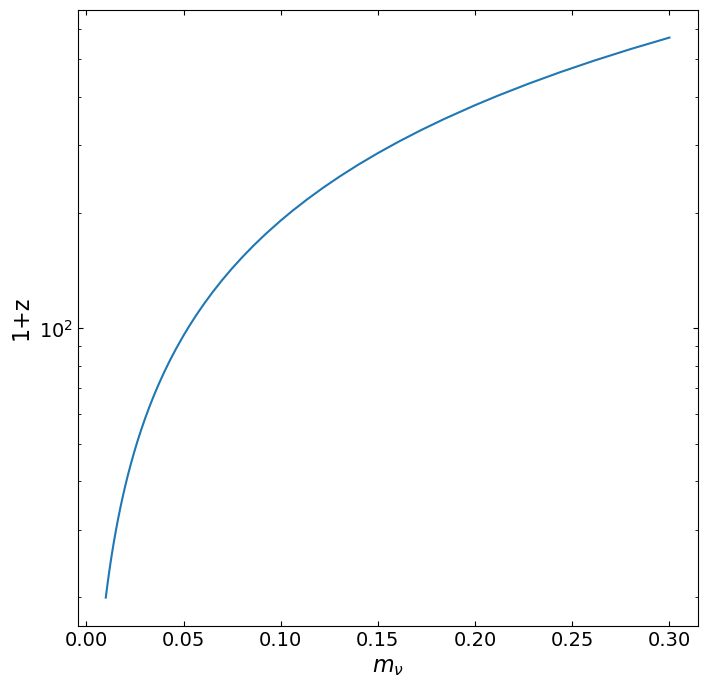

In [9]:
def z_non_rel_avg(m_nu, args):

    return 1100 * (m_nu / 0.58*args.eV)


zeds = z_non_rel_avg(nu_m_range, Params())

plt.semilogy(nu_m_range, 1+zeds)
plt.xlabel(fr"$m_\nu$")
plt.ylabel(fr"1+z")